In [ ]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import random
import json
from shutil import copyfile

import pandas as pd
from glob import glob

In [ ]:
"""torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True"""

In [2]:
all_xray_df = pd.read_csv('F:/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('F:/NIH_Chest_X-ray_Dataset', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [3]:
print(all_xray_df['path'][0].replace('\\','/'))

F:/NIH_Chest_X-ray_Dataset/images_001/images/00000001_000.png


In [4]:
print(all_xray_df['Finding Labels'][0].replace('No Finding','').split('|'))

['Cardiomegaly']


In [5]:
LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
          'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
          'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [6]:
train_list = []
test_list = []

for i, sample_img_path in enumerate(all_xray_df['path']):
    if random.randrange(0,10) == 0:
        image_labels = all_xray_df['Finding Labels'][i].replace('No Finding','').split('|')
        if image_labels != ['']:
            test_list.append({'image_name': sample_img_path.replace('\\','/'),
                               'image_labels': image_labels})
        else:
            test_list.append({'image_name': sample_img_path.replace('\\','/'),
                               'image_labels': []})
    else:
        image_labels = all_xray_df['Finding Labels'][i].replace('No Finding','').split('|')
        if image_labels != ['']:
            train_list.append({'image_name': sample_img_path.replace('\\','/'),
                               'image_labels': image_labels})
        else:
            train_list.append({'image_name': sample_img_path.replace('\\','/'),
                               'image_labels': []})
with open('train.json', 'w') as fp:
    json.dump({'samples': train_list, 'labels': LABELS}, fp, indent=3)
with open('test.json', 'w') as fp:
    json.dump({'samples': test_list, 'labels': LABELS}, fp, indent=3)

In [2]:
class NIHDataset(Dataset):
    def __init__(self, anno_path, transforms):
        self.transforms = transforms
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        img_path = os.path.join(self.imgs[item])
        img = Image.open(img_path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

    def __len__(self):
        return len(self.imgs)

loading test.json
loading train.json


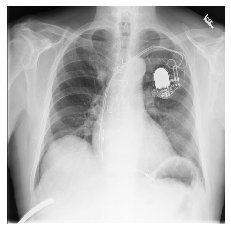

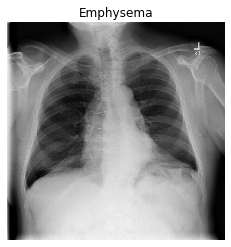

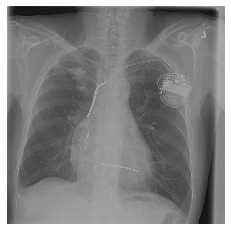

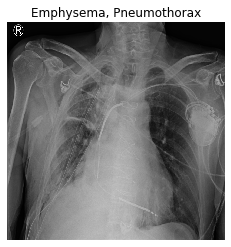

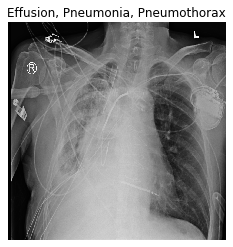

In [3]:
dataset_val = NIHDataset(os.path.join('test.json'), None)
dataset_train = NIHDataset(os.path.join('train.json'), None)

def show_sample(img, binary_img_labels):
    img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    show_sample(*dataset_val[sample_id])

Label distribution (count, class name): [(227, 'Hernia'), (1431, 'Pneumonia'), (1686, 'Fibrosis'), (2303, 'Edema'), (2516, 'Emphysema'), (2776, 'Cardiomegaly'), (3385, 'Pleural_Thickening'), (4667, 'Consolidation'), (5302, 'Pneumothorax'), (5782, 'Mass'), (6331, 'Nodule'), (11559, 'Atelectasis'), (13317, 'Effusion'), (19894, 'Infiltration')]


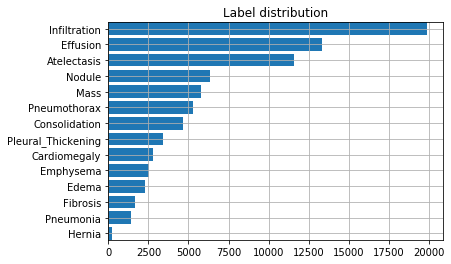

In [4]:
samples = dataset_val.annos + dataset_train.annos
samples = np.array(samples)
with printoptions(precision=3, suppress=True):
    class_counts = np.sum(samples, axis=0)
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    print('Label distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(dataset_val.classes)[sorted_ids])))
    plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.yticks(range(len(dataset_val.classes)), np.array(dataset_val.classes)[sorted_ids])
    plt.gca().margins(y=0)
    plt.grid()
    plt.title('Label distribution')
    plt.show()

In [5]:
class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [6]:
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro', zero_division=True),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro', zero_division=True),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro', zero_division=True),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro', zero_division=True),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro', zero_division=True),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro', zero_division=True),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples', zero_division=True),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples', zero_division=True),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples', zero_division=True),
            }

In [7]:
num_workers = 0
lr = 1e-4 # 1e-3# 
batch_size = 32
save_freq = 1 
test_freq = 200 
max_epoch_number = 35 


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

device = torch.device("cuda:0")

save_path = 'chekpoints/'

logdir = 'logs/'

#%load_ext tensorboard
#%tensorboard --logdir {logdir}

In [8]:
def checkpoint_save(model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

In [10]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(),
    #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
    #                        shear=None, resample=False, 
    #                        fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

(123.675, 116.28, 103.53)


In [11]:
test_annotations = os.path.join('test.json')
train_annotations = os.path.join('train.json')

test_dataset = NIHDataset(test_annotations, val_transform)
train_dataset = NIHDataset(train_annotations, train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                              drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

num_train_batches = int(np.ceil(len(train_dataset) / batch_size))

model = Resnet18(len(train_dataset.classes))
model.train()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)"""

os.makedirs(save_path, exist_ok=True)

criterion = nn.BCELoss()
logger = SummaryWriter(logdir)

loading test.json
loading train.json


In [12]:
epoch = 0
iteration = 0
while True:
    batch_losses = []
    for imgs, targets in train_dataloader:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))
        #print(model_result)
        #print(targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        logger.add_scalar('train_loss', batch_loss_value, iteration)
        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            result = calculate_metrics(model_result.cpu().numpy(), targets.cpu().numpy())
            for metric in result:
                logger.add_scalar('train/' + metric, result[metric], iteration)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in test_dataloader:
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(np.array(model_result), np.array(targets))
            for metric in result:
                logger.add_scalar('test/' + metric, result[metric], iteration)
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(model, save_path, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

epoch: 0 iter:  0 test: micro f1: 0.091 macro f1: 0.066 samples f1: 0.077
epoch: 0 iter:200 test: micro f1: 0.073 macro f1: 0.021 samples f1: 0.542
epoch: 0 iter:400 test: micro f1: 0.085 macro f1: 0.034 samples f1: 0.546
epoch: 0 iter:600 test: micro f1: 0.127 macro f1: 0.087 samples f1: 0.553
epoch: 0 iter:800 test: micro f1: 0.155 macro f1: 0.077 samples f1: 0.560
epoch: 0 iter:1000 test: micro f1: 0.212 macro f1: 0.087 samples f1: 0.559
epoch: 0 iter:1200 test: micro f1: 0.124 macro f1: 0.071 samples f1: 0.557
epoch: 0 iter:1400 test: micro f1: 0.138 macro f1: 0.106 samples f1: 0.557
epoch: 0 iter:1600 test: micro f1: 0.249 macro f1: 0.113 samples f1: 0.560
epoch: 0 iter:1800 test: micro f1: 0.115 macro f1: 0.081 samples f1: 0.555
epoch: 0 iter:2000 test: micro f1: 0.153 macro f1: 0.094 samples f1: 0.564
epoch: 0 iter:2200 test: micro f1: 0.195 macro f1: 0.118 samples f1: 0.569
epoch: 0 iter:2400 test: micro f1: 0.220 macro f1: 0.128 samples f1: 0.571
epoch: 0 iter:2600 test: micro

epoch: 6 iter:20400 test: micro f1: 0.277 macro f1: 0.227 samples f1: 0.551


KeyboardInterrupt: 

In [ ]:
model.eval()
for sample_id in [1,2,3,4,6]:
    test_img, test_labels = test_dataset[sample_id]
    test_img_path = os.path.join(test_dataset.imgs[sample_id])
    with torch.no_grad():
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = ['no predictions']
    img_labels = np.array(dataset_val.classes)[np.argwhere(test_labels > 0)[:, 0]]
    plt.imshow(Image.open(test_img_path))
    plt.title("Predicted labels: {} \nGT labels: {}".format(', '.join(predicted_labels), ', '.join(img_labels)))
    plt.axis('off')
    plt.show()